In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
#import optuna
#from optuna.integration import SklearnSearchCV


In [2]:
# Carga la base de datos desde un archivo csv
df = pd.read_csv('diabetic_data_modified.csv')
df.head()

,Unnamed: 0,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,0,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,0,0,0,0,0,0,0,No,No,NO
1,1,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,0,0,0,0,0,0,2,Ch,Yes,>30
2,2,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,0,0,1,0,0,0,0,No,Yes,NO
3,3,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,0,0,0,0,0,0,2,Ch,Yes,NO
4,4,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,0,0,1,0,0,0,1,Ch,Yes,NO


In [3]:
df = df.drop(columns=["Unnamed: 0","patient_nbr",], axis=1)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,0,0,0,0,0,0,0,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,0,0,0,0,0,0,2,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,0,0,1,0,0,0,0,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,0,0,0,0,0,0,2,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,0,0,1,0,0,0,1,Ch,Yes,NO


In [4]:
df.select_dtypes(include=['category', 'object'])


,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),Diabetes mellitus,Other,Other,Not taken,Not taken,No,No,NO
1,Caucasian,Female,[10-20),Other,Diabetes mellitus,Other,Not taken,Not taken,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),Other,Diabetes mellitus,Other,Not taken,Not taken,No,Yes,NO
3,Caucasian,Male,[30-40),Other,Diabetes mellitus,Diseases of the circulatory system,Not taken,Not taken,Ch,Yes,NO
4,Caucasian,Male,[40-50),Neoplasms,Neoplasms,Diabetes mellitus,Not taken,Not taken,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...
71513,Caucasian,Female,[70-80),Diseases of the digestive system,Diseases of the digestive system,Diabetes mellitus,Not taken,>7,Ch,Yes,>30
71514,Other,Female,[40-50),Diseases of the genitourinary system,Diseases of the genitourinary system,Diseases of the respiratory system,Not taken,>8,Ch,Yes,>30
71515,Other,Female,[60-70),Injury and poisoning,Diseases of the genitourinary system,Diseases of the circulatory system,Not taken,Not taken,No,Yes,>30
71516,Caucasian,Female,[80-90),Other,Other,Other,Not taken,Not taken,Ch,Yes,NO


In [5]:
df.select_dtypes(include=['int', 'float'])

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin
0,6,25,1,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0
1,1,1,7,3,59,0,18,0,0,0,9,0,0,0,0,0,0,2
2,1,1,7,2,11,5,13,2,0,1,6,0,0,1,0,0,0,0
3,1,1,7,2,44,1,16,0,0,0,7,0,0,0,0,0,0,2
4,1,1,7,1,51,0,8,0,0,0,5,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,1,1,7,9,50,2,33,0,0,0,9,0,0,0,2,0,0,1
71514,1,1,7,14,73,6,26,0,1,0,9,0,0,1,0,0,0,2
71515,1,1,7,2,46,6,17,1,1,1,9,0,0,0,0,0,0,1
71516,1,1,7,5,76,1,22,0,1,0,9,0,0,0,0,0,0,2


In [6]:
# Muestra los valores unicos de la columna que sera el target
valores_unicos = df['readmitted'].unique()
valores_unicos

array(['NO', '>30', '<30'], dtype=object)

In [7]:
# Reemplazar 'NO' por 0 y cualquier otro valor por 1
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})

C:\Users\Guille\AppData\Local\Temp\ipykernel_23380\4078068006.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})


In [8]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,0,0,0,0,0,0,0,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,0,0,0,0,0,0,2,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,0,0,1,0,0,0,0,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,0,0,0,0,0,0,2,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,0,0,1,0,0,0,1,Ch,Yes,0


In [9]:
print(df.readmitted.value_counts())
plt.figure(figsize=(7,5))
sns.countplot(x='readmitted', data=df)

readmitted
0    42985
1    22240
2     6293
Name: count, dtype: int64


NameError: name 'plt' is not defined

In [10]:
df.shape

(71518, 29)

In [11]:
# Selecciona automáticamente las columnas categóricas del DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns

# Realiza codificación one-hot manualmente para cada columna categórica
encoded_columns = pd.get_dummies(df[categorical_columns])

# Convierte las columnas codificadas one-hot en valores numéricos
encoded_columns = encoded_columns.astype(int)

# Concatena las columnas codificadas one-hot con el DataFrame original
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_columns], axis=1)

df_encoded

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,max_glu_serum_Norm,max_glu_serum_Not taken,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,A1Cresult_Not taken,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,6,25,1,1,41,0,1,0,0,0,...,0,1,0,0,0,1,0,1,1,0
1,1,1,7,3,59,0,18,0,0,0,...,0,1,0,0,0,1,1,0,0,1
2,1,1,7,2,11,5,13,2,0,1,...,0,1,0,0,0,1,0,1,0,1
3,1,1,7,2,44,1,16,0,0,0,...,0,1,0,0,0,1,1,0,0,1
4,1,1,7,1,51,0,8,0,0,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,1,1,7,9,50,2,33,0,0,0,...,0,1,1,0,0,0,1,0,0,1
71514,1,1,7,14,73,6,26,0,1,0,...,0,1,0,1,0,0,1,0,0,1
71515,1,1,7,2,46,6,17,1,1,1,...,0,1,0,0,0,1,0,1,0,1
71516,1,1,7,5,76,1,22,0,1,0,...,0,1,0,0,0,1,1,0,0,1


In [12]:
df_encoded.shape

(71518, 76)

In [13]:
df_encoded.columns

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'readmitted', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_[0-10)', 'age_[10-20)', 'age_[20-30)',
       'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)',
       'age_[70-80)', 'age_[80-90)', 'age_[90-100)',
       'diag_1_Diabetes mellitus', 'diag_1_Diseases of the circulatory system',
       'diag_1_Diseases of the digestive system',
       'diag_1_Diseases of the genitourinary system',
       'diag_1_Diseases of the musculoskeletal system and connective tissue',
       'diag_1_Diseases of th

In [14]:
# Define las features y la variable target
X = df_encoded.drop('readmitted', axis=1)  # Features
y = df_encoded['readmitted']  # Target variable

In [14]:
# Separa los datos de entrenamiento y evaulacion
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [17]:
X_train.shape

(57214, 75)

Creacion del modelo

In [38]:
def build_model(n_neurons=5, input_shape=(X_train.shape[1],)):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_neurons, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))  # Cambiamos a 3 neuronas y softmax

    # Utilizamos categorical_crossentropy para problemas de clasificación multiclase
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
# Crea un clasificador de Keras que es compatible con scikit-learn
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=100, validation_split=0.2)

C:\Users\Guille\AppData\Local\Temp\ipykernel_21420\1618677641.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=100, validation_split=0.2)


In [40]:
# Crea un pipeline en scikit-learn. Un pipeline es una secuencia de transformaciones y un estimador final. 
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [41]:
# Inicia el entrenamiento del modelo de keras
model.fit(X_train,y_train)

Epoch 1/100
1431/1431 [==============================] - 2s 1ms/step - loss: 0.9184 - accuracy: 0.5862 - val_loss: 0.8887 - val_accuracy: 0.6011
Epoch 2/100
1431/1431 [==============================] - 1s 871us/step - loss: 0.8851 - accuracy: 0.5979 - val_loss: 0.8795 - val_accuracy: 0.6015
Epoch 3/100
1431/1431 [==============================] - 1s 876us/step - loss: 0.8787 - accuracy: 0.5980 - val_loss: 0.8739 - val_accuracy: 0.6014
Epoch 4/100
1431/1431 [==============================] - 1s 910us/step - loss: 0.8746 - accuracy: 0.5981 - val_loss: 0.8703 - val_accuracy: 0.6017
Epoch 5/100
1431/1431 [==============================] - 1s 863us/step - loss: 0.8716 - accuracy: 0.5980 - val_loss: 0.8677 - val_accuracy: 0.6019
Epoch 6/100
1431/1431 [==============================] - 1s 883us/step - loss: 0.8692 - accuracy: 0.5981 - val_loss: 0.8653 - val_accuracy: 0.6020
Epoch 7/100
1431/1431 [==============================] - 1s 883us/step - loss: 0.8671 - accuracy: 0.5981 - val_loss: 0.8

Pipeline(steps=[('scale', StandardScaler()),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D798961D60>)])

In [42]:
# Predice según los datos de testeo e imprime los resultados con cuatro decimales
y_fit = model.predict(X_test)
print(classification_report(y_test, y_fit, digits=4))

447/447 [==============================] - 0s 587us/step
              precision    recall  f1-score   support

           0     0.6382    0.9178    0.7528      8732
           1     0.4570    0.1810    0.2593      4408
           2     0.0000    0.0000    0.0000      1164

    accuracy                         0.6161     14304
   macro avg     0.3651    0.3663    0.3374     14304
weighted avg     0.5304    0.6161    0.5395     14304



c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [17]:
# Limpia el modelo anteior para liberar espacio en memoria
keras.backend.clear_session()

### Se procedera a buscar los mejores hiperparametros para el modelo

In [16]:
def build_model(n_hidden=1, n_neurons=5, input_shape=(X_train.shape[1],), num_classes=2):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_neurons, activation='relu', input_shape=input_shape))

    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))

    # Capa de salida adaptada para el número de clases
    if num_classes == 2:
        model.add(keras.layers.Dense(1, activation='sigmoid'))  # Clasificación binaria
        loss = 'binary_crossentropy'
    else:
        model.add(keras.layers.Dense(num_classes, activation='softmax'))  # Clasificación multiclase
        loss = 'categorical_crossentropy'

    model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])
    return model

In [17]:
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=50, verbose=0)

C:\Users\Guille\AppData\Local\Temp\ipykernel_1272\854310640.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=50, verbose=0)


In [19]:
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [20]:
# Diccionario con los hiperparametros a testear
params = {
    'ann__n_hidden':[0,1,2,3,4,5],
    'ann__n_neurons':np.arange(0,30),
    'ann__batch_size':[10,15,20,25,30]
}

In [21]:
rnd_search = RandomizedSearchCV(model, params, n_iter=10, cv=3, n_jobs=-1, verbose=2)

In [22]:
grid_result = rnd_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [27]:
grid_result.best_params_

{'ann__n_neurons': 1, 'ann__n_hidden': 4, 'ann__batch_size': 25}

In [28]:
sk_params = {
    'batch_size':grid_result.best_params_['ann__batch_size'],
    'n_hidden': grid_result.best_params_['ann__n_hidden'],
    'n_neurons':grid_result.best_params_['ann__n_neurons']
}

In [29]:
sk_params

{'batch_size': 25, 'n_hidden': 4, 'n_neurons': 1}

In [30]:
keras.backend.clear_session()

In [31]:
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=20, verbose=1, **sk_params )

C:\Users\Guille\AppData\Local\Temp\ipykernel_1272\2354317905.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=20, verbose=1, **sk_params )


In [32]:
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [33]:
model.fit(X_train,y_train)

Epoch 1/20
2289/2289 [==============================] - 2s 892us/step - loss: 0.6931 - accuracy: 0.5905
Epoch 2/20
2289/2289 [==============================] - 2s 884us/step - loss: 0.6930 - accuracy: 0.5987
Epoch 3/20
2289/2289 [==============================] - 2s 924us/step - loss: 0.6931 - accuracy: 0.5987
Epoch 4/20
2289/2289 [==============================] - 2s 894us/step - loss: 0.6930 - accuracy: 0.5987
Epoch 5/20
2289/2289 [==============================] - 2s 887us/step - loss: 0.6931 - accuracy: 0.5987
Epoch 6/20
2289/2289 [==============================] - 2s 862us/step - loss: 0.6930 - accuracy: 0.5935
Epoch 7/20
2289/2289 [==============================] - 2s 862us/step - loss: 0.6930 - accuracy: 0.5984
Epoch 8/20
2289/2289 [==============================] - 2s 988us/step - loss: 0.6931 - accuracy: 0.5987
Epoch 9/20
2289/2289 [==============================] - 3s 1ms/step - loss: 0.6930 - accuracy: 0.5987
Epoch 10/20
2289/2289 [==============================] - 2s 916us/

Pipeline(steps=[('scale', StandardScaler()),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000210922F7400>)])

447/447 [==============================] - 0s 688us/step
              precision    recall  f1-score   support

           0     0.6105    1.0000    0.7581      8732
           1     0.0000    0.0000    0.0000      4408
           2     0.0000    0.0000    0.0000      1164

    accuracy                         0.6105     14304
   macro avg     0.2035    0.3333    0.2527     14304
weighted avg     0.3727    0.6105    0.4628     14304



c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

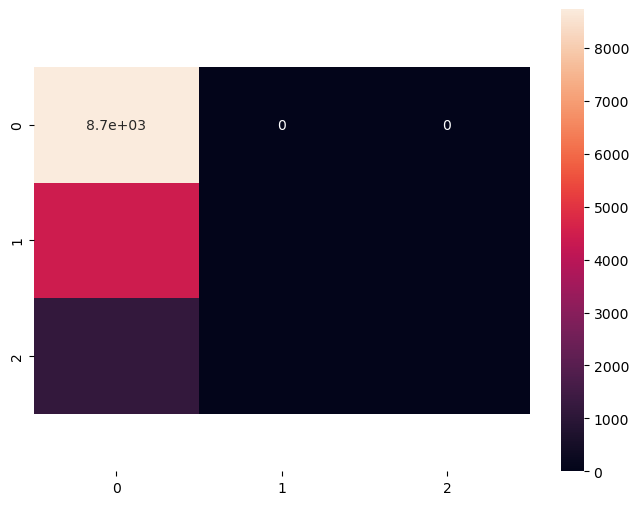

In [34]:
y_fit = model.predict(X_test)

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_fit)
sns.heatmap(conf_matrix, annot=True)  # Utiliza fmt=".4f" para imprimir números con 4 decimales
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

# Imprimir el informe de clasificación con números con 4 decimales
print(classification_report(y_test, y_fit, digits=4))


***

In [103]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
df = pd.read_csv('diabetic_data_modified.csv')
df = df.drop(columns=["Unnamed: 0","patient_nbr",], axis=1)
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 1})
categorical_columns = df.select_dtypes(include=['object']).columns
encoded_columns = pd.get_dummies(df[categorical_columns])
encoded_columns = encoded_columns.astype(int)
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_columns], axis=1)
X = df_encoded.drop('readmitted', axis=1)  # Features
y = df_encoded['readmitted']  # Target variable

C:\Users\Guille\AppData\Local\Temp\ipykernel_25592\3020703118.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 1})


In [105]:
# Preprocesar tus datos
X = df_encoded.drop('readmitted', axis=1).values.astype(np.float32)  # Obtener características como matriz numpy
y = df_encoded['readmitted'].values.astype(np.float32)       # Obtener etiquetas como matriz numpy

In [106]:
# Dividir datos en conjuntos de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()

# Convertir y_test a un array de NumPy y luego a tensor de PyTorch
y_test_np = y_test.astype(int)  # Convertir a tipo int si no lo está
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long).cuda()

In [109]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test, dtype=torch.long).cuda()

In [110]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [111]:
# Configuración del modelo
input_dim = X_train.shape[1]
output_dim = len(df['readmitted'].unique())
model = Classifier(input_dim, output_dim).cuda()

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/2000], Loss: 0.5604511499404907
Epoch [1001/2000], Loss: 0.5604326128959656


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

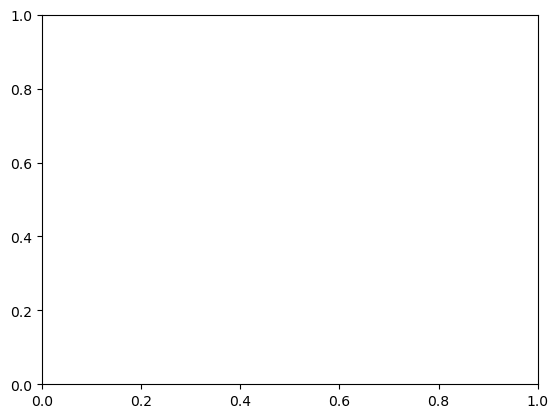

In [114]:
# Entrenamiento del modelo
epochs = 1000
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# Graficar las métricas durante el entrenamiento
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      8732
           1       0.49      0.41      0.44      5572

    accuracy                           0.60     14304
   macro avg       0.57      0.57      0.57     14304
weighted avg       0.59      0.60      0.59     14304



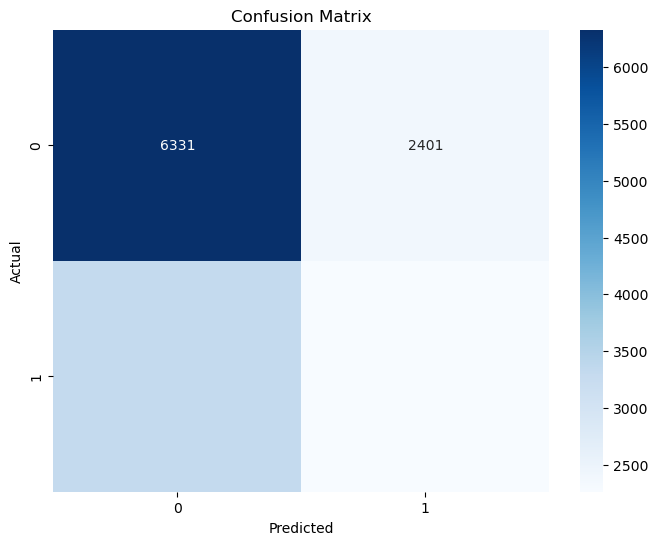

In [ ]:
# Evaluación en datos de prueba
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Mostrar métricas
print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

# Graficar matriz de confusión
cm = confusion_matrix(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['readmitted'].unique(), yticklabels=df['readmitted'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

***

In [ ]:
df = pd.read_csv('diabetic_data_modified.csv')
df = df.drop(columns=["Unnamed: 0","patient_nbr",], axis=1)
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 1})
categorical_columns = df.select_dtypes(include=['object']).columns
encoded_columns = pd.get_dummies(df[categorical_columns])
encoded_columns = encoded_columns.astype(int)
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_columns], axis=1)
X = df_encoded.drop('readmitted', axis=1)  # Features
y = df_encoded['readmitted']  # Target variable